In [94]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape, Polygon
import shapely
import os
import sys
sys.path.append('/home/vaschetti/maxarSrc/datasets_and_samplers')
from myGeoDatasets import Maxar
from mySamplers import MyGridGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
from samplers_utils import boundingBox_2_Polygon
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2
import supervision as sv
import json
import time as tm

In [69]:
path = '/home/vaschetti/maxarSrc/creating_labels/MSRoads/data/AfricaWest-Full/AfricaWest-Full.tsv'
road_df = pd.read_csv(path, names =['country', 'geometry'] ,delimiter='\t')
country = 'GMB'
road_df = road_df[road_df['country'] == country]
road_df['geometry'] = road_df['geometry'].apply(json.loads).apply(lambda d: shape(d.get('geometry')))
road_gdf = gpd.GeoDataFrame(road_df, crs=4326)

In [40]:
"""def make_gis_friendly(df):
    df['geometry'] = df['geometry'].apply(shape)
    gdf = gpd.GeoDataFrame(df, crs=4326)
    gdf.to_file(f"{road_df.iloc[0]['country']}_roads.geojson", driver="GeoJSON")

make_gis_friendly(road_df)"""

In [108]:
dataset = Maxar('/mnt/data2/vaschetti_data/maxar/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031213.tif')
sample_size = 600
sampler = MyGridGeoSampler(dataset, size=sample_size, stride=600)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)
data_crs = dataset.crs
road_gdf_32628 = road_gdf.to_crs(data_crs)

In [113]:
def rel_line_coords(geodf: gpd.GeoDataFrame,
                    query_bbox_poly: Polygon,
                    res):
    """
    Returns the relative coordinates of a polygon w.r.t. a reference bbox

    Inputs:
        geodf: GeoDataFrame containing the Linestring
        query_bbox_poly: Polygon of the reference bbox
        res: resolution of the image
    Returns:
        result: list of lists of tuples with the relative coordinates
    """
    ref_coords = query_bbox_poly.bounds
    ref_minx, ref_maxy = ref_coords[0], ref_coords[3] #coords of top left corner

    result = []
    for line in geodf.geometry:
        x_s, y_s = line.coords.xy
        rel_x_s = (np.array(x_s) - ref_minx) / res
        rel_y_s = (ref_maxy - np.array(y_s)) / res
        rel_coords = list(zip(rel_x_s, rel_y_s))
        result.append(rel_coords)
    return result

In sampler
tile_polygon:  POLYGON ((320156.25 1489843.75, 315455.322265625 1489843.75, 315470.63516642543 1492342.8892077415, 320156.25 1491748.5059546148, 320156.25 1489843.75))
POLYGON ((315393.06640625 1489843.75, 315576.171875 1489843.75, 315576.171875 1490026.85546875, 315393.06640625 1490026.85546875, 315393.06640625 1489843.75))
POLYGON ((315576.171875 1489843.75, 315759.27734375 1489843.75, 315759.27734375 1490026.85546875, 315576.171875 1490026.85546875, 315576.171875 1489843.75))
POLYGON ((315759.27734375 1489843.75, 315942.3828125 1489843.75, 315942.3828125 1490026.85546875, 315759.27734375 1490026.85546875, 315759.27734375 1489843.75))
POLYGON ((315942.3828125 1489843.75, 316125.48828125 1489843.75, 316125.48828125 1490026.85546875, 315942.3828125 1490026.85546875, 315942.3828125 1489843.75))
POLYGON ((316125.48828125 1489843.75, 316308.59375 1489843.75, 316308.59375 1490026.85546875, 316125.48828125 1490026.85546875, 316125.48828125 1489843.75))
POLYGON ((316308.59375 1489

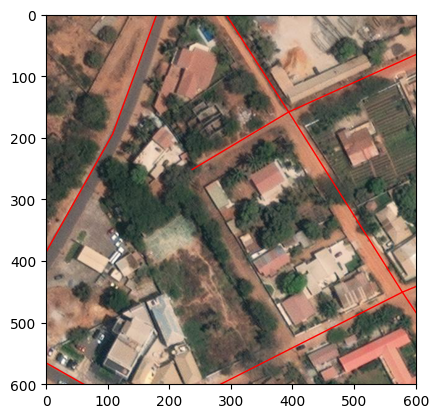

In [115]:
dataset_res = dataset.res
i=0
for batch in dataloader:
    query_bbox_poly = boundingBox_2_Polygon(batch['bbox'][0])
    print(query_bbox_poly)
    hits = road_gdf_32628.geometry.intersects(query_bbox_poly)
    queried_road_gdf_36628 = road_gdf_32628[hits]
    if len(queried_road_gdf_36628) > 5:
        sample = unbind_samples(batch)[0]
        img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')

        fig, ax2 = dataset.plot(sample)
        lines_points = rel_line_coords(queried_road_gdf_36628, query_bbox_poly, dataset_res)

        for line in lines_points:
            ax2.plot(*zip(*line), color='red', linewidth=1)

        #sample = unbind_samples(batch)[0]
        #img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')        
        #print(building_boxes[0])
        ax2.set_xlim([0, sample_size])
        ax2.set_ylim([sample_size, 0])
        
        break